# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing My Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. I will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. I will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, I should start by asking questions i might want to understand about the bike share data, for example, if i were working for Motivate. What kinds of information would you want to know about in order to make smarter business decisions? If you were a user of the bike-share service, what factors might influence how you would want to use the service?

Let's write questions related to bike sharing that could be answered by data.

- In What day of the week people uses bikeshare the most? 
- What's the diffrence between a subscriber and a customer? 
- How much is the cost for each city? 
- when is the most popular time of uses for each city? 
- what route people use the most?


<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, I will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

I noticed that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly.The data has already been collected in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

However, there is still a lot of data to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze.

In [18]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # print data structures like dictionaries in
                          # a nicer way than the base print function.

In [19]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        # set up a DictReader object
        trip_reader = csv.DictReader(f_in)
        
        # read the first trip from the data file and store it in a variable
        first_trip = next(trip_reader)
        
        #print the first trip
        pprint(first_trip)
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

We can see below the printout of each city name (which has been parsed from the data file name) that the first trip has been parsed in the form of a dictionary. Which contain data like the Duration for the trip, The Starting point and ending point, the member type and other informations about the consumer.


<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, i will trim and clean the data.

I will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, i will convert the Washington labels to match the other two.

In [20]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    """
    
    # Converted Chicago and NYC from seconds to minutes.
    if city == 'Chicago':
        duration = float(datum['tripduration']) /60
    elif city == 'NYC':
        duration = float(datum['tripduration']) /60
    # Coverted Washington from milliseconds to minutes.
    elif city == 'Washington':
        duration = float(datum['Duration (ms)']) /60000
    # Return the trip duration
    return duration


# Some tests to check that the code works. There should be no output if all of
# the assertions pass.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [21]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    """

    # used the datetime module to get some useful functions.
    if city == 'Chicago':
        dt = datetime.strptime(datum['starttime'], "%m/%d/%Y %H:%M")
    elif city == 'Washington':
        dt = datetime.strptime(datum['Start date'], "%m/%d/%Y %H:%M")
    # included the seconds in NYC since it have the data.
    elif city == 'NYC':
        dt = datetime.strptime(datum['starttime'], "%m/%d/%Y %H:%M:%S")
    month = dt.month
    hour = dt.hour
    days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    weekday = dt.date().weekday()
    day_of_week = days[weekday]
    return (month, hour, day_of_week)


# tests to check that the code works. There should be no output if all of
# the assertions pass.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [22]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    if city == 'Chicago':
        user_type = datum['usertype']
    elif city == 'Washington':
        if datum['Member Type'] == 'Registered':
            user_type = 'Subscriber'
        else:
            user_type = 'Customer'
    elif city == 'NYC':
        user_type = datum['usertype']
    return user_type


# tests to check that the code works. There should be no output if all of
# the assertions pass. 
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

Now, I will create a condensed data file for each city consisting only of the data fields indicated above.

In [23]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        # set up csv DictReader object
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            # getting the cleaned data from the original data dictionaries
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'] = time_of_trip(row, city)[0]
            new_point['hour'] = time_of_trip(row, city)[1]
            new_point['day_of_week'] = time_of_trip(row,city)[2]
            new_point['user_type'] = type_of_user(row, city)

            # writing the processed information to the output file
            trip_writer.writerow(new_point)
            

In [24]:
# Test to check that the code works
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that the data has been collected and wrangled, it's time to start exploring the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers.

**Questions :**

Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

**Answers :**

NYC has the highest number of trips (245896), Also NYC has the highest proportion of trips made by subscribers (88.84%), But Chicago has the highest proportion made by short-term customers (23.77%). 

In [25]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        sub_prop = (n_subscribers/n_total) *100
        cust_prop = (n_customers/n_total) *100
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total, sub_prop, cust_prop)

In [26]:
data_files = ['./data/Washington-2016-Summary.csv',
              './data/Chicago-2016-Summary.csv',
              './data/NYC-2016-Summary.csv']

for data_file in data_files:
    print(number_of_trips(data_file))


City: Washington
(51753, 14573, 66326, 78.0282242257938, 21.971775774206193)

City: Chicago
(54982, 17149, 72131, 76.22520136973007, 23.774798630269924)

City: NYC
(245896, 30902, 276798, 88.83590199351151, 11.164098006488485)


**Questions :**

Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

**Answers :** 

The average trip length for Washington is 18.93 minutes and the proportion of rides made that are longer than 30 minutes is 10.83%, The average trip length for Chicago is 16.56 minutes and the proportion of rides made that are longer than 30 minutes is 8.33%, The average trip length for NYC is 15.81 minutes and the proportion of rides made that are longer than 30 minutes is 7.30%.

In [27]:
def avg_trip(filename):
    """ 
    This function read in a file with trip data and return the average duration of a trip length as well
    the proportion of long trips that is over 30 minutes
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    # set up csv reader object
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        # initialize count variables
        total_trips = 0
        total_trip_leng = 0
        trip_over_30 = 0
        # trip count and trip length add
        for i in reader:
            total_trips += 1
            total_trip_leng += float(i['duration'])
            if float(i['duration']) > 30:
                trip_over_30 += 1
        # Calculate the average trip length
        avg_length = (total_trip_leng/total_trips)
        prop_over_30 = (trip_over_30/total_trips)*100
        # return the average length and the proportion of long trips over 30 mins
        return (avg_length, prop_over_30)


In [28]:
# Get the data
data_files = ['./data/Washington-2016-Summary.csv',
              './data/Chicago-2016-Summary.csv',
              './data/NYC-2016-Summary.csv']
for data_file in data_files:
    print(avg_trip(data_file))


City: Washington
(18.93287355913721, 10.83888671109369)

City: Chicago
(16.563629368787335, 8.332062497400562)

City: NYC
(15.81259299802294, 7.3024371563378345)


**Question :** 

Which type of user takes longer rides on average in Washington: Subscribers or Customers?

**Answer**: 

- Customers in Washington take longer rides on average of **41.67** minutes, And the average time of subscribers taking rides is **12.52** minutes.
- Customers in Chicago take longer rides on average **30.97** minutes, And the average time of subscribers taking rides is **12.06** minutes.
- Customers in NYC take longer rides on average of **32.77** minutes, And the average time of subscribers taking rides is **13.68** minutes.

In [29]:
def rider_duration(filename):
    """
    this function read in a file with trip data and return the ridership by 
    subscribers and customers and then calculate the average rider duration for both.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    # set up csv reader object
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        # initialize count variables
        subs = 0
        sub_duration = 0
        cust = 0
        cust_duration = 0
        # subscribers and customers add
        for i in reader:
            if i['user_type'] == 'Subscriber':
                subs += 1
                sub_duration += float(i['duration'])
            else:
                cust += 1
                cust_duration += float(i['duration'])
        # Calculate the average
        avg_subs = sub_duration / subs
        avg_cust = cust_duration / cust
        # Return the average 
        return (avg_subs, avg_cust)

In [30]:
# Get the data
data_washington = './data/Washington-2016-Summary.csv'
data_chicago = './data/Chicago-2016-Summary.csv'
data_NYC = './data/NYC-2016-Summary.csv'

# Print out the info
print(rider_duration(data_washington))
print(rider_duration(data_chicago))
print(rider_duration(data_NYC))


City: Washington
(12.528120499294745, 41.67803139252976)

City: Chicago
(12.067201690250076, 30.979781133982506)

City: NYC
(13.680790523907177, 32.77595139473187)


<a id='visualizations'></a>
### Visualizations

The last set of values that computed pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting to look at how the trip times are distributed.
The cell below to load the library and to generate an example plot.

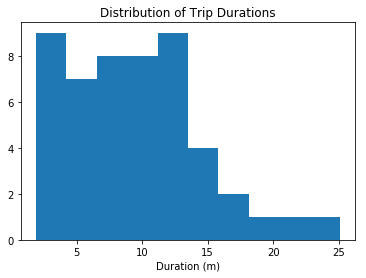

In [31]:
# load library
import matplotlib.pyplot as plt

%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, I collected fifty trip times in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

I will now use these functions to create a histogram of the trip times for Washington city.

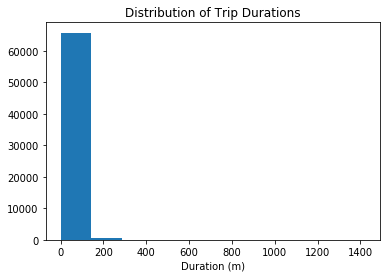

In [32]:
def trip_info(filename):
    """
    This function read in a file with trip data and return the number
    of trips made by subscribers and customers.
    """
    # List to contain the data
    trip_data = []
    # set up csv reader object
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        # Add the duration to the list
        for i in reader:
            trip_data.append(float(i['duration']))
    # return the data
    return trip_data

# Get the data
data_washington = './data/Washington-2016-Summary.csv'
washington_plot = trip_info(data_washington)

# plot the data in a histogram
plt.hist(washington_plot)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

The plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. Take a look at the duration values on the x-axis. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, I will use additional parameters with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

**Question :** 

Where is the peak in NYC distribution? How would you describe the shape of the distribution?

**Answer :** 

The peak for the subscribers in Washington is around 5 to 10 Minutes and the customers around 15 to 25 Minutes, And they both are skewed towards the right.

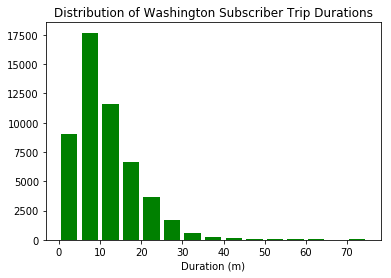

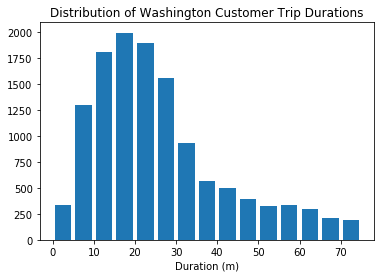

In [33]:
# Lists to contain data
subs_data = []
cust_data = []

def sub_trip_info(filename):
    # set up csv reader object
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        # Add up Subscriber ride information
        for i in reader:
            if i['user_type'] == 'Subscriber':
                subs_data.append(float(i['duration']))
        # Return the data
        return subs_data

def cust_trip_info(filename):
    # set up csv reader object
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        # Add up Customers ride information
        for i in reader:
            if i['user_type'] == 'Customer':
                cust_data.append(float(i['duration']))
        # Return the data
        return cust_data

# Get the data
data_washington = './data/Washington-2016-Summary.csv'

subs_washington_plot = sub_trip_info(data_washington)
cust_washington_plot = cust_trip_info(data_washington)

# bins for 5 minutes wide
bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]

# Plot for subscribers in Washington
plt.hist(subs_washington_plot, bins, rwidth=0.8, color='g')
plt.title('Distribution of Washington Subscriber Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

# Plot for customers in Washington
plt.hist(cust_washington_plot, bins, rwidth=0.8)
plt.title('Distribution of Washington Customer Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

<a id='eda_continued'></a>
## Performing My Own Analysis

So far, I performed an initial exploration into the data available. I compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, I investigated differences between Subscribers and Customers in terms of how long a typical trip lasts.

**Question :**

Is the pattern of ridership different on the weekends versus weekdays?

What is the average weekday/weekend ride times in Washington?

**Answer :**

The pattern is both right skewed for weekday and weekend in Washington, And the peak is around 10 minutes for both weekdays and weekend, The average trip for weekday is (17.02) minutes and for weekend is (24.40) minutes.

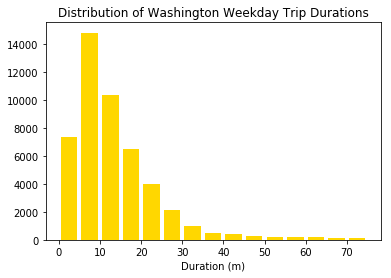

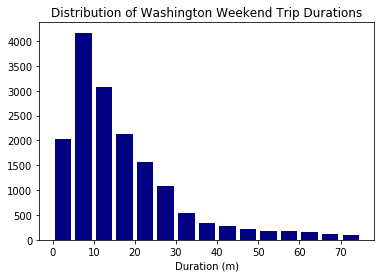

In [34]:
def weekdays_plot(filename):
    """ Plot a histogram for a given city weekday """
    # set up csv reader object
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        # List to contain data
        week_days = []
        # Add up the weekdays data
        for i in reader:
            if i['day_of_week'] == 'Monday':
                week_days.append(float(i['duration']))
            elif i['day_of_week'] == 'Tuesday':
                week_days.append(float(i['duration']))
            elif i['day_of_week'] == 'Wednesday':
                week_days.append(float(i['duration']))
            elif i['day_of_week'] == 'Thursday':
                week_days.append(float(i['duration']))
            elif i['day_of_week'] == 'Friday':
                week_days.append(float(i['duration']))
        # Return the data
        return (week_days)

# Get the data    
data_washington = './data/Washington-2016-Summary.csv'
weekday_washington = weekdays_plot(data_washington)

# bins for 5 minutes wide
bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
# Plot for weekdays in Washington

plt.hist(weekday_washington, bins, rwidth=0.8, color='gold')
plt.title('Distribution of Washington Weekday Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

def weekend_plot(filename):
    """ Plot a histogram for a given city weekend """
    # set up csv reader object
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        # List to contain data
        weekend_days = []
        # Add up the weekend data
        for i in reader:
            if i['day_of_week'] == 'Saturday':
                weekend_days.append(float(i['duration']))
            elif i['day_of_week'] == 'Sunday':
                weekend_days.append(float(i['duration']))
        # Return the data
        return weekend_days

# Get the data
data_washington = './data/Washington-2016-Summary.csv'
weekend_washington = weekend_plot(data_washington)

# Plot for weekends in washington
plt.hist(weekend_washington, bins, rwidth=0.8, color='navy')
plt.title('Distribution of Washington Weekend Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In [35]:
def avg_weekday_weekend(filename):
    """ 
    This function read in a file with trip data and return the average
    trip ride that has been made in weekdays and weekends
    """
    # set up csv reader object
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        # initialize count variables
        n_weekday = 0
        n_weekend = 0
        dur_weekday = 0
        dur_weekend = 0
        # Add up the weekdays and weekend duration and trips
        for i in reader:
            if i['day_of_week'] == 'Monday':
                dur_weekday += float(i['duration'])
                n_weekday += 1
            elif i['day_of_week'] == 'Tuesday':
                dur_weekday += float(i['duration'])
                n_weekday += 1
            elif i['day_of_week'] == 'Wednesday':
                dur_weekday += float(i['duration'])
                n_weekday += 1
            elif i['day_of_week'] == 'Thursday':
                dur_weekday += float(i['duration'])
                n_weekday += 1
            elif i['day_of_week'] == 'Friday':
                dur_weekday += float(i['duration'])
                n_weekday += 1
            elif i['day_of_week'] == 'Saturday':
                dur_weekend += float(i['duration'])
                n_weekend += +1
            elif i['day_of_week'] == 'Sunday':
                dur_weekend += float(i['duration'])
                n_weekend += 1
        # Calculate the average for weekdays and weekends        
        avg_weekday = dur_weekday / n_weekday
        avg_weekend = dur_weekend / n_weekend
        # Return the average
        return(avg_weekday, avg_weekend)

# Get the data    
data_washington = './data/Washington-2016-Summary.csv'
avg_washington_weekday, avg_washington_weekend = avg_weekday_weekend(data_washington)

#print out the average for weekday and weekend
print('Average weekday ride time in washington is :{} minutes.'.format(avg_washington_weekday))
print('Average weekend ride time in washington is :{} minutes.'.format(avg_washington_weekend))

Average weekday ride time in washington is :17.02673047724554 minutes.
Average weekend ride time in washington is :24.408457928027808 minutes.


<a id='conclusions'></a>
## Conclusions

This is only a sampling of the data analysis process: from generating questions, wrangling the data, and to exploring the data. Normally, at this point in the data analysis process, There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

In [36]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0